### Librerías

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

### Funciones

In [3]:
def regression_analysis(df, features, target):
    """
    Realiza un análisis de regresión lineal sobre el DataFrame proporcionado.

    Args:
    df (pd.DataFrame): DataFrame que contiene las características y la variable dependiente.
    features (list): Lista de strings con los nombres de las características (features).
    target (str): Nombre de la variable dependiente.

    Returns:
    pd.DataFrame: DataFrame con los resultados del análisis de regresión.
    """
    
    # Normalizar los datos
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

    # Variable dependiente
    y = df_scaled[target]
    results = []

    # Iterar sobre el número de características a usar
    for num_features in range(1, len(features) + 1):
        for feature_combination in combinations(features, num_features):
            # Opción 1: Sin constante
            X = df_scaled[list(feature_combination)]
            
            # Ajustar el modelo de regresión lineal sin constante usando statsmodels
            model = sm.OLS(y, X).fit()
            
            # Calcular R^2
            r2 = model.rsquared
            
            # Calcular el número condicional
            number_condition = np.linalg.cond(X)
            
            # Guardar los resultados sin constante
            results.append({
                'Features': feature_combination,
                'R^2': r2,
                'Conditional Number': number_condition,
                'Constant Included': False,
                'modelo': model
            })
            
            # Opción 2: Con constante
            X_const = sm.add_constant(X)  # Añadir constante usando statsmodels
            
            # Ajustar el modelo de regresión lineal con constante
            model_const = sm.OLS(y, X_const).fit()
            
            # Calcular R^2 con constante
            r2_const = model_const.rsquared
            
            # Calcular el número condicional con constante
            number_condition_const = np.linalg.cond(X_const)
            
            # Guardar los resultados con constante
            results.append({
                'Features': feature_combination,
                'R^2': r2_const,
                'Conditional Number': number_condition_const,
                'Constant Included': True,
                'modelo': model_const
            })

    # Convertir los resultados a DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df



def regresion(X, y, const=1):
    """
    Perform OLS regression.

    Parameters:
    X : DataFrame or ndarray
        Independent variables.
    y : Series or ndarray
        Dependent variable.
    const : int, optional
        Whether to include a constant (default is 1, include constant).

    Returns:
    results : RegressionResults
        Results of the regression.
    """
    if const == 1:
        X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

### Datos

In [3]:
#df rios
df_closest_rios = pd.read_csv('BBDD/df_closest_rios.csv')
df_rios_canales = pd.read_csv('BBDD/df_rios_canales.csv')
df_rios_canales['date'] = pd.to_datetime(df_rios_canales['date'])
df_merge_riosCanales = pd.merge(df_closest_rios[['pixel_copernicus', 'id_station']], df_rios_canales, on='id_station', how = 'inner')
df_merge_riosCanales = df_merge_riosCanales.rename(columns = {'quantity_hm3': 'quantity_hm3_riosCanales'})
df_merge_riosCanales['quantity_hm3_riosCanales'] = df_merge_riosCanales['quantity_hm3_riosCanales'].str.replace(',', '.')
df_merge_riosCanales['quantity_hm3_riosCanales'] = df_merge_riosCanales['quantity_hm3_riosCanales'].fillna(0)
df_merge_riosCanales['quantity_hm3_riosCanales'] = df_merge_riosCanales['quantity_hm3_riosCanales'].astype('float')
df_merge_riosCanales = df_merge_riosCanales[df_merge_riosCanales['date'].dt.year >= 1960]

# Cantidad de estaciones de aforo de ríos por fecha y pìxel
n_estaciones_rios = df_merge_riosCanales.groupby(['date', 'pixel_copernicus'])['id_station'].count().reset_index()
n_estaciones_rios = n_estaciones_rios.rename(columns = {'id_station': 'n_estaciones_rios'})

# df embalses
df_closest_embalses = pd.read_csv('BBDD/df_closest_embalses.csv')
df_embalses_cedex = pd.read_csv('BBDD/df_embalses_cedex.csv')
df_merge_embalses = pd.merge(df_closest_embalses[['pixel_copernicus', 'id_station']], df_embalses_cedex, on='id_station', how = 'inner')
df_merge_embalses = df_merge_embalses.rename(columns = {'quantity_hm3': 'quantity_hm3_embalses'})
df_merge_embalses['date'] = pd.to_datetime(df_merge_embalses['date'])
df_merge_embalses = df_merge_embalses[df_merge_embalses['date'].dt.year >= 1960]

#Cantidad de estaciones de afoto de embalses por fecha y pixel
n_estaciones_embalses = df_merge_embalses.groupby(['date', 'pixel_copernicus'])['id_station'].count().reset_index()
n_estaciones_embalses = n_estaciones_embalses.rename(columns = {'id_station': 'n_estaciones_embalses'})

#unión embalses rios
df_merge_embalses_rios = pd.merge(df_merge_embalses,df_merge_riosCanales, on = ['pixel_copernicus','date'], how = 'outer')
df_merge_embalses_rios = df_merge_embalses_rios[['pixel_copernicus','date','quantity_hm3_embalses','quantity_hm3_riosCanales']]
df_merge_embalses_rios  =df_merge_embalses_rios.fillna(0)

#Unión con copernicus
df_copernicus = pd.read_csv('BBDD/df_copernicus.csv')
df_copernicus['date'] = pd.to_datetime(df_copernicus['date'])
df_merge_rios_embalses = pd.merge(df_copernicus, df_merge_embalses_rios, right_on = ['pixel_copernicus','date'],left_on=['pixel','date'], how = 'left')
df_merge_rios_embalses = df_merge_rios_embalses.fillna(0)
df_merge_rios_embalses = df_merge_rios_embalses[['pixel', 'date','total_precipitation', 
       'skin_temperature', 'evaporation', 'runoff', 'snowfall',
       'soil_water_l1', 'soil_water_l2', 'soil_water_l3', 'soil_water_l4',
       'high_vegetation_cover', 'low_vegetation_cover', 'type_high_vegetation',
       'type_low_vegetation', 'quantity_hm3_embalses',
       'quantity_hm3_riosCanales']]

In [4]:
#Enlazar soil water los 4 niveles en uno solo
df_merge_rios_embalses['soil_water'] = df_merge_rios_embalses['soil_water_l1'] + df_merge_rios_embalses['soil_water_l2'] + df_merge_rios_embalses['soil_water_l3'] + df_merge_rios_embalses['soil_water_l4']
df_merge_rios_embalses = df_merge_rios_embalses.drop(['soil_water_l1', 'soil_water_l2', 'soil_water_l3','soil_water_l4'], axis = 1)
df_merge_rios_embalses['soil_water'] = df_merge_rios_embalses['soil_water']/1e+6 #pasar a hectómetros cúbicos que es la unidad en la que está la cantidad de agua en ríos y embalses
#LLuvia en hectómetros cúbicos
dist_lat_km = 55.71
dist_lon_km = 43.71
# Calcular la superficie para cada coordenada (en km^2)
surface_km2 = dist_lat_km * dist_lon_km
df_merge_rios_embalses['total_precipitation'] = (df_merge_rios_embalses['total_precipitation']*surface_km2)/1e+6 #para calcular los hectómetros cúbicos que han llovido
#Runoff en hectómetros cúbicos
df_merge_rios_embalses['runoff'] = (df_merge_rios_embalses['runoff']*surface_km2)/1e+6 
#Snowfall en hectómetros cúbicos
df_merge_rios_embalses['snowfall'] = (df_merge_rios_embalses['snowfall']*surface_km2)/1e+6 

## Agrupamos por pixel de copernicus para quitar duplicados
df_merge_rios_embalses = df_merge_rios_embalses.groupby(['pixel','date']).sum().reset_index()

#Unión con estaciones de aforo
estaciones_aforo = pd.merge(n_estaciones_embalses, n_estaciones_rios, on = ['date', 'pixel_copernicus'], how = 'outer').fillna(0)
df_merge_rios_embalses = pd.merge(df_merge_rios_embalses, estaciones_aforo,left_on = ['date', 'pixel'] ,right_on = ['date', 'pixel_copernicus'], how = 'inner')

df_merge_rios_embalses.set_index('date', inplace=True)

### Creción de nuevas variables

##### Cantidad de agua por estación de aforo

Utilizaremos como variable a explicar cantidad de agua por estación de aforo. Esto es porque vemos que las estaciones de aforo aumentan a lo largo del tiempo:

In [12]:
df_merge_rios_embalses['hm3_estacion_embalse'] = (df_merge_rios_embalses['quantity_hm3_embalses'] / df_merge_rios_embalses['n_estaciones_embalses']).fillna(0)
df_merge_rios_embalses['hm3_estacion_rio'] = (df_merge_rios_embalses['quantity_hm3_riosCanales'] / df_merge_rios_embalses['n_estaciones_rios']).fillna(0)

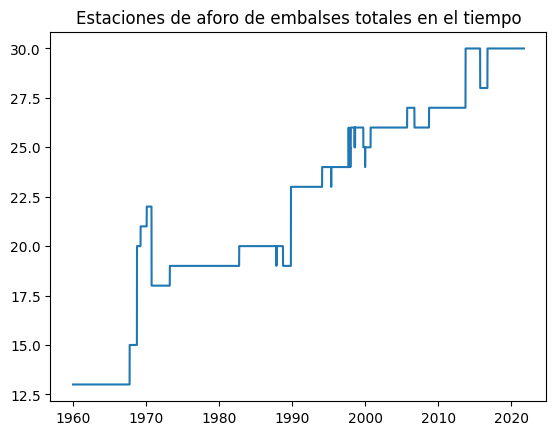

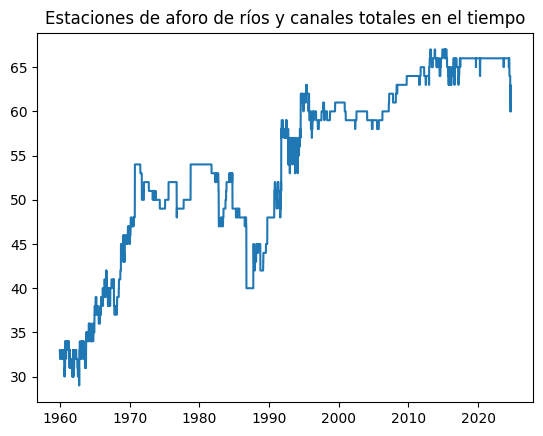

In [13]:
plt.plot(n_estaciones_embalses.groupby('date').sum()['n_estaciones_embalses'])
plt.title('Estaciones de aforo de embalses totales en el tiempo')
plt.show()
plt.plot(n_estaciones_rios.groupby('date').sum()['n_estaciones_rios'])
plt.title('Estaciones de aforo de ríos y canales totales en el tiempo')
plt.show()

In [8]:
df_merge_rios_embalses

,pixel,total_precipitation,skin_temperature,evaporation,runoff,snowfall,high_vegetation_cover,low_vegetation_cover,type_high_vegetation,type_low_vegetation,quantity_hm3_embalses,quantity_hm3_riosCanales,soil_water,pixel_copernicus,n_estaciones_embalses,n_estaciones_rios
date,,,,,,,,,,,,,,,,
1960-01-01,3,0.000000e+00,284.23930,-0.000758,0.000000e+00,0.0,0.000000,0.000000,19.0,1.0,0.0,0.035424,0.000002,3,0.0,1.0
1960-01-02,3,0.000000e+00,284.50177,-0.000682,0.000000e+00,0.0,0.000000,0.000000,19.0,1.0,0.0,0.035424,0.000002,3,0.0,1.0
1960-01-03,3,1.229174e-09,284.36890,-0.000801,0.000000e+00,0.0,0.000000,0.000000,19.0,1.0,0.0,0.035424,0.000002,3,0.0,1.0
1960-01-04,3,1.041651e-09,284.19193,-0.000451,0.000000e+00,0.0,0.000000,0.000000,19.0,1.0,0.0,0.035424,0.000002,3,0.0,1.0
1960-01-05,3,3.503826e-09,284.04755,-0.000434,0.000000e+00,0.0,0.000000,0.000000,19.0,1.0,0.0,0.035424,0.000002,3,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-26,29,3.985111e-08,297.23870,-0.002291,2.313532e-08,0.0,0.185516,0.557006,19.0,1.0,0.0,0.029894,0.000004,29,0.0,1.0
2024-06-27,29,0.000000e+00,297.66925,-0.002790,2.162507e-08,0.0,0.185516,0.557006,19.0,1.0,0.0,0.030154,0.000004,29,0.0,1.0
2024-06-28,29,4.179090e-08,297.41864,-0.002429,2.241896e-08,0.0,0.185516,0.557006,19.0,1.0,0.0,0.016848,0.000004,29,0.0,1.0


##### Agua disponible

Hacemos el cálculo analítico:

$$\text{Agua disponible estimada} = \text{Total precipitation} - \text{evaporation}$$


In [16]:
df_merge_rios_embalses["agua_disponible_estimacion"] = df_merge_rios_embalses['total_precipitation'] - df_merge_rios_embalses['evaporation']

##### Agua disponible acumulada

In [17]:
agua_acum = {}
for pixel in df_merge_rios_embalses['pixel'].unique():
    df_pixel = df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == pixel]
    agua_acum[pixel] = df_pixel['agua_disponible_estimacion'].cumsum().reset_index(drop=True)

agua_acum_combined = pd.concat([pd.Series(v) for v in agua_acum.values()], ignore_index=True)
agua_acum_combined = pd.DataFrame({'date': df_merge_rios_embalses.reset_index()['date'], 'agua_disponible_cum' : agua_acum_combined})
agua_acum_combined.set_index('date', inplace=True)
df_merge_rios_embalses['agua_disponible_cum'] = agua_acum_combined

##### Retardos

Precipitaciones 1 mes, 6 meses y 1 año antes

In [18]:
resultados = []

# Iterar sobre cada píxel único
for pixel in df_merge_rios_embalses['pixel'].unique():
    df_pixel = df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == pixel].copy()
    #df_pixel.set_index('date', inplace=True)
    # Mes anterior
    df_pixel['precipitaciones_mes_anterior'] = (
        df_pixel['total_precipitation'].resample('M').sum().shift(1).reindex(df_pixel.index, method='ffill')
    )

    # Semestre anterior
    df_pixel['precipitaciones_semestre_anterior'] = (
        df_pixel['total_precipitation'].resample('6M').sum().shift(1).reindex(df_pixel.index, method='ffill')
    )

    # Año anterior
    df_pixel['precipitaciones_anio_anterior'] = (
        df_pixel['total_precipitation'].resample('A').sum().shift(1).reindex(df_pixel.index, method='ffill')
    )

    # Agregar el DataFrame resultante a la lista
    resultados.append(df_pixel)
df_merge_rios_embalses =  pd.concat(resultados)

Agua disponible estimada 1 mes, 6 meses y 1 año antes

In [19]:
resultados = []

# Iterar sobre cada píxel único
for pixel in df_merge_rios_embalses['pixel'].unique():
    df_pixel = df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == pixel].copy()
    #df_pixel.set_index('date', inplace=True)
    # Mes anterior
    df_pixel['agDisp_mes_anterior'] = (
        df_pixel['agua_disponible_estimacion'].resample('M').sum().shift(1).reindex(df_pixel.index, method='ffill')
    )

    # Semestre anterior
    df_pixel['agDisp_semestre_anterior'] = (
        df_pixel['agua_disponible_estimacion'].resample('6M').sum().shift(1).reindex(df_pixel.index, method='ffill')
    )

    # Año anterior
    df_pixel['agDisp_año_anterior'] = (
        df_pixel['agua_disponible_estimacion'].resample('A').sum().shift(1).reindex(df_pixel.index, method='ffill')
    )

    # Agregar el DataFrame resultante a la lista
    resultados.append(df_pixel)
df_merge_rios_embalses =  pd.concat(resultados)

añadir variables de uso de agua como variable explicativa

añadir variable a explicar variables cantidad de aguas subterraneas


### Correlaciones e importancias

In [20]:
df_merge_rios_embalses = df_merge_rios_embalses.fillna(0)

#### Total

##### hm3 total

In [21]:
correlaciones = df_merge_rios_embalses.corr()
print(correlaciones['quantity_hm3_embalses'].sort_values(ascending=False))

quantity_hm3_embalses                1.000000
hm3_estacion_embalse                 0.831646
n_estaciones_embalses                0.512621
high_vegetation_cover                0.355199
skin_temperature                     0.335983
type_high_vegetation                 0.335467
low_vegetation_cover                 0.310198
soil_water                           0.301189
precipitaciones_semestre_anterior    0.280373
precipitaciones_anio_anterior        0.277357
agDisp_semestre_anterior             0.257598
agDisp_año_anterior                  0.244764
precipitaciones_mes_anterior         0.240666
agua_disponible_estimacion           0.240188
quantity_hm3_riosCanales             0.240058
agDisp_mes_anterior                  0.237405
agua_disponible_cum                  0.206440
hm3_estacion_rio                     0.134073
total_precipitation                  0.094965
type_low_vegetation                  0.059429
runoff                               0.050113
n_estaciones_rios                 

In [22]:
from sklearn.tree import DecisionTreeRegressor
X = df_merge_rios_embalses[['total_precipitation', 'skin_temperature', 'evaporation',
       'runoff', 'snowfall', 'high_vegetation_cover',
       'type_high_vegetation', 'type_low_vegetation',
       'quantity_hm3_riosCanales', 'soil_water', 'agua_disponible_estimacion',
       'precipitaciones_mes_anterior', 'precipitaciones_semestre_anterior',
       'precipitaciones_anio_anterior', 'agDisp_mes_anterior',
       'agDisp_semestre_anterior', 'agDisp_año_anterior']]
y = df_merge_rios_embalses[['quantity_hm3_embalses']]
X = X.copy().fillna(X.mean())
y = y.copy().fillna(y.mean())
model = DecisionTreeRegressor()  # Ajusta max_depth según sea necesario
model.fit(X, y)
importances = pd.DataFrame({'Variable': ['total_precipitation', 'skin_temperature', 'evaporation',
       'runoff', 'snowfall', 'high_vegetation_cover',
       'type_high_vegetation', 'type_low_vegetation',
       'quantity_hm3_riosCanales', 'soil_water', 'agua_disponible_estimacion',
       'precipitaciones_mes_anterior', 'precipitaciones_semestre_anterior',
       'precipitaciones_anio_anterior', 'agDisp_mes_anterior',
       'agDisp_semestre_anterior', 'agDisp_año_anterior'], 'Importancia': model.feature_importances_})

# Ordenar las variables por importancia
importances = importances.sort_values(by='Importancia', ascending=False)
print(importances)

                             Variable  Importancia
1                    skin_temperature     0.405734
5               high_vegetation_cover     0.297851
16                agDisp_año_anterior     0.102567
6                type_high_vegetation     0.047439
13      precipitaciones_anio_anterior     0.046424
15           agDisp_semestre_anterior     0.037079
12  precipitaciones_semestre_anterior     0.028291
8            quantity_hm3_riosCanales     0.013427
14                agDisp_mes_anterior     0.007965
9                          soil_water     0.006993
11       precipitaciones_mes_anterior     0.004082
7                 type_low_vegetation     0.001335
2                         evaporation     0.000467
10         agua_disponible_estimacion     0.000190
0                 total_precipitation     0.000112
3                              runoff     0.000038
4                            snowfall     0.000006


##### Hm3 por estación

In [25]:
correlaciones = df_merge_rios_embalses.drop(['quantity_hm3_embalses'],axis = 1).corr()
print(correlaciones['hm3_estacion_embalse'].sort_values(ascending=False))

hm3_estacion_embalse                 1.000000
n_estaciones_embalses                0.155987
high_vegetation_cover                0.042612
soil_water                           0.020350
precipitaciones_mes_anterior         0.013113
skin_temperature                     0.011822
type_high_vegetation                 0.011796
precipitaciones_semestre_anterior    0.006548
evaporation                          0.004958
snowfall                             0.002628
total_precipitation                  0.002296
precipitaciones_anio_anterior       -0.000248
runoff                              -0.002285
agua_disponible_estimacion          -0.004849
quantity_hm3_riosCanales            -0.007156
low_vegetation_cover                -0.011068
agDisp_mes_anterior                 -0.013227
agDisp_semestre_anterior            -0.013949
agua_disponible_cum                 -0.021060
agDisp_año_anterior                 -0.023028
hm3_estacion_rio                    -0.039776
pixel                             

In [26]:
from sklearn.tree import DecisionTreeRegressor
X = df_merge_rios_embalses[['total_precipitation', 'skin_temperature', 'evaporation',
       'runoff', 'snowfall', 'high_vegetation_cover',
       'type_high_vegetation', 'type_low_vegetation',
       'quantity_hm3_riosCanales', 'soil_water', 'agua_disponible_estimacion',
       'precipitaciones_mes_anterior', 'precipitaciones_semestre_anterior',
       'precipitaciones_anio_anterior', 'agDisp_mes_anterior',
       'agDisp_semestre_anterior', 'agDisp_año_anterior']]
y = df_merge_rios_embalses[['hm3_estacion_embalse']]
X = X.copy().fillna(X.mean())
y = y.copy().fillna(y.mean())
model = DecisionTreeRegressor()  # Ajusta max_depth según sea necesario
model.fit(X, y)
importances = pd.DataFrame({'Variable': ['total_precipitation', 'skin_temperature', 'evaporation',
       'runoff', 'snowfall', 'high_vegetation_cover',
       'type_high_vegetation', 'type_low_vegetation',
       'quantity_hm3_riosCanales', 'soil_water', 'agua_disponible_estimacion',
       'precipitaciones_mes_anterior', 'precipitaciones_semestre_anterior',
       'precipitaciones_anio_anterior', 'agDisp_mes_anterior',
       'agDisp_semestre_anterior', 'agDisp_año_anterior'], 'Importancia': model.feature_importances_})

# Ordenar las variables por importancia
importances = importances.sort_values(by='Importancia', ascending=False)
print(importances)

                             Variable  Importancia
1                    skin_temperature     0.378250
5               high_vegetation_cover     0.318449
16                agDisp_año_anterior     0.122766
15           agDisp_semestre_anterior     0.051689
13      precipitaciones_anio_anterior     0.048060
12  precipitaciones_semestre_anterior     0.041090
8            quantity_hm3_riosCanales     0.025227
14                agDisp_mes_anterior     0.006438
11       precipitaciones_mes_anterior     0.003630
9                          soil_water     0.001654
7                 type_low_vegetation     0.001281
6                type_high_vegetation     0.000637
2                         evaporation     0.000378
10         agua_disponible_estimacion     0.000309
0                 total_precipitation     0.000112
3                              runoff     0.000025
4                            snowfall     0.000004


#### Por pixel

##### Embalses

Arbol 

In [29]:
# DataFrame para almacenar los resultados con las variables como índice
df_importances_total = pd.DataFrame()

# Iteramos por cada píxel único
for pixel in df_merge_rios_embalses['pixel'].unique():
    df_pixel = df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == pixel]
    
    # Solo procedemos si hay datos válidos
    if df_pixel['hm3_estacion_embalse'].max() != 0:
        X = df_pixel[['total_precipitation', 'skin_temperature', 'evaporation',
                      'runoff', 'snowfall', 'high_vegetation_cover',
                      'type_high_vegetation', 'type_low_vegetation',
                      'quantity_hm3_riosCanales', 'soil_water', 'agua_disponible_estimacion',
                      'precipitaciones_mes_anterior', 'precipitaciones_semestre_anterior',
                      'precipitaciones_anio_anterior', 'agDisp_mes_anterior',
                      'agDisp_semestre_anterior', 'agDisp_año_anterior']]
        
        y = df_pixel[['hm3_estacion_embalse']]  # Asegúrate de que esté filtrado por píxel
        
        # Rellenar valores nulos con la media de las columnas
        X = X.copy().fillna(X.mean())
        y = y.copy().fillna(y.mean())
        
        # Crear y ajustar el modelo de regresión
        model = DecisionTreeRegressor()  # Ajusta max_depth si es necesario
        model.fit(X, y)
        
        # Crear DataFrame de importancias para las variables
        importances = pd.DataFrame({
            'Variable': ['total_precipitation', 'skin_temperature', 'evaporation',
                         'runoff', 'snowfall', 'high_vegetation_cover',
                         'type_high_vegetation', 'type_low_vegetation',
                         'quantity_hm3_riosCanales', 'soil_water', 'agua_disponible_estimacion',
                         'precipitaciones_mes_anterior', 'precipitaciones_semestre_anterior',
                         'precipitaciones_anio_anterior', 'agDisp_mes_anterior',
                         'agDisp_semestre_anterior', 'agDisp_año_anterior'],
            'Importancia': model.feature_importances_
        })
        
        # Establecer la columna 'Variable' como índice y renombrar la columna de importancias con el nombre del píxel
        importances.set_index('Variable', inplace=True)
        importances.rename(columns={'Importancia': f'Pixel_{pixel}'}, inplace=True)
        
        # Acumular los resultados en el DataFrame total
        if df_importances_total.empty:
            df_importances_total = importances
        else:
            df_importances_total = df_importances_total.join(importances, how='outer')


In [33]:
df_importances_total.T.mean().sort_values(ascending=False)

Variable
precipitaciones_anio_anterior        0.188742
agDisp_año_anterior                  0.172080
precipitaciones_semestre_anterior    0.103881
quantity_hm3_riosCanales             0.101733
agDisp_semestre_anterior             0.089995
soil_water                           0.087790
skin_temperature                     0.077867
type_high_vegetation                 0.073688
agDisp_mes_anterior                  0.044371
high_vegetation_cover                0.027171
precipitaciones_mes_anterior         0.020066
type_low_vegetation                  0.004513
agua_disponible_estimacion           0.003743
evaporation                          0.002219
total_precipitation                  0.001380
runoff                               0.000622
snowfall                             0.000140
dtype: float64

Correlaciones

In [90]:
# DataFrame para almacenar los resultados con las variables como índice
df_correlations_total = {}
# Iteramos por cada píxel único
for pixel in df_merge_rios_embalses['pixel'].unique():
    df_pixel = df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == pixel]
    
    # Solo procedemos si hay datos válidos
    if df_pixel['hm3_estacion_embalse'].max() != 0:
        # Seleccionamos las variables climáticas y la variable de interés (hm3_estacion_embalse)
        X = df_pixel[['total_precipitation', 'skin_temperature', 'evaporation', 'quantity_hm3_riosCanales',
                      'runoff', 'snowfall', 'high_vegetation_cover',
                      'type_high_vegetation', 'type_low_vegetation',
                      'quantity_hm3_riosCanales', 'soil_water', 'agua_disponible_estimacion',
                      'precipitaciones_mes_anterior', 'precipitaciones_semestre_anterior',
                      'precipitaciones_anio_anterior', 'agDisp_mes_anterior',
                      'agDisp_semestre_anterior', 'agDisp_año_anterior']]
        
        y = df_pixel['hm3_estacion_embalse']  # Variable de interés (cantidad de agua en embalses)
        
        # Calcular la correlación entre cada variable climática y 'hm3_estacion_embalse'
        correlations = X.corrwith(y)
        
        # Crear DataFrame de correlaciones para el píxel actual
        correlations_df = pd.DataFrame({
            'Variable': correlations.index,
            f'Pixel_{pixel}': correlations.values
        })
        df_correlations_total[f'Pixel_{pixel}'] = correlations

# Ahora `df_correlations_total` tiene una columna por píxel y las variables en las filas
df_correlations_total = pd.DataFrame(df_correlations_total)

C:\Users\nacho\mambaforge\envs\myenv\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\nacho\mambaforge\envs\myenv\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\nacho\mambaforge\envs\myenv\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\nacho\mambaforge\envs\myenv\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [93]:
df_correlations_total.T.mean().sort_values(ascending=False)

type_low_vegetation                  0.437802
type_high_vegetation                 0.437802
high_vegetation_cover                0.406531
skin_temperature                     0.371393
soil_water                           0.359134
agDisp_semestre_anterior             0.296795
precipitaciones_semestre_anterior    0.289037
precipitaciones_anio_anterior        0.285714
agua_disponible_estimacion           0.263167
precipitaciones_mes_anterior         0.256951
agDisp_año_anterior                  0.236667
agDisp_mes_anterior                  0.223359
quantity_hm3_riosCanales             0.190489
quantity_hm3_riosCanales             0.190489
total_precipitation                  0.062808
runoff                               0.041090
snowfall                             0.012910
evaporation                         -0.262566
dtype: float64

##### Ríos

In [100]:
# DataFrame para almacenar los resultados con las variables como índice
df_importances_total = pd.DataFrame()

# Iteramos por cada píxel único
for pixel in df_merge_rios_embalses['pixel'].unique():
    df_pixel = df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == pixel]
    
    # Solo procedemos si hay datos válidos
    if df_pixel['quantity_hm3_riosCanales'].max() != 0:
        X = df_pixel[['total_precipitation', 'skin_temperature', 'evaporation','hm3_estacion_embalse',
                      'runoff', 'snowfall', 'high_vegetation_cover',
                      'type_high_vegetation', 'type_low_vegetation', 'soil_water', 'agua_disponible_estimacion',
                      'precipitaciones_mes_anterior', 'precipitaciones_semestre_anterior',
                      'precipitaciones_anio_anterior', 'agDisp_mes_anterior',
                      'agDisp_semestre_anterior', 'agDisp_año_anterior']]
        
        y = df_pixel[['quantity_hm3_riosCanales']]  # Asegúrate de que esté filtrado por píxel
        
        # Rellenar valores nulos con la media de las columnas
        X = X.copy().fillna(X.mean())
        y = y.copy().fillna(y.mean())
        
        # Crear y ajustar el modelo de regresión
        model = DecisionTreeRegressor()  # Ajusta max_depth si es necesario
        model.fit(X, y)
        
        # Crear DataFrame de importancias para las variables
        importances = pd.DataFrame({
            'Variable': ['total_precipitation', 'skin_temperature', 'evaporation','hm3_estacion_embalse',
                      'runoff', 'snowfall', 'high_vegetation_cover',
                      'type_high_vegetation', 'type_low_vegetation', 'soil_water', 'agua_disponible_estimacion',
                      'precipitaciones_mes_anterior', 'precipitaciones_semestre_anterior',
                      'precipitaciones_anio_anterior', 'agDisp_mes_anterior',
                      'agDisp_semestre_anterior', 'agDisp_año_anterior'],
            'Importancia': model.feature_importances_
        })
        
        # Establecer la columna 'Variable' como índice y renombrar la columna de importancias con el nombre del píxel
        importances.set_index('Variable', inplace=True)
        importances.rename(columns={'Importancia': f'Pixel_{pixel}'}, inplace=True)
        
        # Acumular los resultados en el DataFrame total
        if df_importances_total.empty:
            df_importances_total = importances
        else:
            df_importances_total = df_importances_total.join(importances, how='outer')
df_importances_total.T.mean().sort_values(ascending=False)

Variable
skin_temperature                     0.195951
soil_water                           0.130827
hm3_estacion_embalse                 0.100544
agDisp_mes_anterior                  0.075950
agDisp_año_anterior                  0.074950
precipitaciones_semestre_anterior    0.074392
agDisp_semestre_anterior             0.069727
precipitaciones_anio_anterior        0.066473
precipitaciones_mes_anterior         0.054183
total_precipitation                  0.052852
runoff                               0.040573
evaporation                          0.025168
agua_disponible_estimacion           0.022415
high_vegetation_cover                0.006038
type_high_vegetation                 0.004833
snowfall                             0.002869
type_low_vegetation                  0.002255
dtype: float64

In [101]:
# DataFrame para almacenar los resultados con las variables como índice
df_correlations_total = {}
# Iteramos por cada píxel único
for pixel in df_merge_rios_embalses['pixel'].unique():
    df_pixel = df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == pixel]
    
    # Solo procedemos si hay datos válidos
    if df_pixel['quantity_hm3_riosCanales'].max() != 0:
        # Seleccionamos las variables climáticas y la variable de interés (hm3_estacion_embalse)
        X = df_pixel[['total_precipitation', 'skin_temperature', 'evaporation', 'hm3_estacion_embalse',
                      'runoff', 'snowfall', 'high_vegetation_cover',
                      'type_high_vegetation', 'type_low_vegetation', 'soil_water', 'agua_disponible_estimacion',
                      'precipitaciones_mes_anterior', 'precipitaciones_semestre_anterior',
                      'precipitaciones_anio_anterior', 'agDisp_mes_anterior',
                      'agDisp_semestre_anterior', 'agDisp_año_anterior']]
        
        y = df_pixel['quantity_hm3_riosCanales']  # Variable de interés (cantidad de agua en embalses)
        
        # Calcular la correlación entre cada variable climática y 'hm3_estacion_embalse'
        correlations = X.corrwith(y)
        
        # Crear DataFrame de correlaciones para el píxel actual
        correlations_df = pd.DataFrame({
            'Variable': correlations.index,
            f'Pixel_{pixel}': correlations.values
        })
        df_correlations_total[f'Pixel_{pixel}'] = correlations

# Ahora `df_correlations_total` tiene una columna por píxel y las variables en las filas
df_correlations_total = pd.DataFrame(df_correlations_total)
df_correlations_total.T.mean().sort_values(ascending=False)

C:\Users\nacho\mambaforge\envs\myenv\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\nacho\mambaforge\envs\myenv\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\nacho\mambaforge\envs\myenv\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\nacho\mambaforge\envs\myenv\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\nacho\mambaforge\envs\myenv\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\nacho\mambaforge\envs\myenv\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\nacho\mambafo

soil_water                           0.308630
type_high_vegetation                 0.247936
type_low_vegetation                  0.247936
agua_disponible_estimacion           0.223418
high_vegetation_cover                0.221837
skin_temperature                     0.203125
agDisp_semestre_anterior             0.200362
hm3_estacion_embalse                 0.190489
runoff                               0.172717
precipitaciones_mes_anterior         0.172561
precipitaciones_semestre_anterior    0.158961
agDisp_mes_anterior                  0.143665
total_precipitation                  0.135151
precipitaciones_anio_anterior        0.132376
agDisp_año_anterior                  0.109844
snowfall                             0.016712
evaporation                         -0.222219
dtype: float64

### Regresiones

In [258]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_merge_rios_embalses), columns=df_merge_rios_embalses.columns, index=df_merge_rios_embalses.index)
regresion(X =df_scaled[['high_vegetation_cover',
                        'skin_temperature',
                        'total_precipitation',
                        'precipitaciones_mes_anterior',
                        'precipitaciones_semestre_anterior',
                        'precipitaciones_anio_anterior',
                        'agua_disponible_estimacion',
                        'agDisp_mes_anterior',
                        'agDisp_semestre_anterior',
                        'agDisp_año_anterior']] , y = df_scaled['quantity_hm3_embalses'], const=0).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     quantity_hm3_embalses   R-squared (uncentered):                   0.157
Model:                               OLS   Adj. R-squared (uncentered):              0.157
Method:                    Least Squares   F-statistic:                              8353.
Date:                   Wed, 09 Oct 2024   Prob (F-statistic):                        0.00
Time:                           22:24:32   Log-Likelihood:                     -5.9691e+05
No. Observations:                 447661   AIC:                                  1.194e+06
Df Residuals:                     447651   BIC:                                  1.194e+06
Df Model:                             10                                                  
Covariance Type:               nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
high_vegetation_cover                 0.8402      0.011     74.992      0.000       0.818       0.862
skin_temperature                     -0.2397      0.012    -19.432      0.000      -0.264      -0.216
total_precipitation                  -0.0093      0.001     -6.342      0.000      -0.012      -0.006
precipitaciones_mes_anterior          0.0396      0.002     17.641      0.000       0.035       0.044
precipitaciones_semestre_anterior     0.0059      0.004      1.397      0.163      -0.002       0.014
precipitaciones_anio_anterior         0.2053      0.006     33.801      0.000       0.193       0.217
agua_disponible_estimacion            0.0248      0.003      8.723      0.000       0.019       0.030
agDisp_mes_anterior                  -0.1005      0.004    -28.209      0.000      -0.107      -0.093
agDisp_semestre_anterior             -0.0373      0.006     -6.167      0.000      -0.049      -0.025
agDisp_año_anterior                  -0.4101      0.008    -53.035      0.000      -0.425      -0.395
==============================================================================
Omnibus:                   279029.979   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2677489.910
Skew:                           2.972   Prob(JB):                         0.00
Kurtosis:                      13.403   Cond. No.                         33.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### hm3_estacion_embalse

In [273]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_merge_rios_embalses), columns=df_merge_rios_embalses.columns, index=df_merge_rios_embalses.index)
regresion(X =df_scaled[['high_vegetation_cover',
                        'skin_temperature',
                        'agDisp_año_anterior',
                        'precipitaciones_anio_anterior'
                        ]] , y = df_scaled['hm3_estacion_embalse'], const=0).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     hm3_estacion_embalse   R-squared (uncentered):                   0.053
Model:                              OLS   Adj. R-squared (uncentered):              0.053
Method:                   Least Squares   F-statistic:                              6229.
Date:                  Wed, 09 Oct 2024   Prob (F-statistic):                        0.00
Time:                          22:43:06   Log-Likelihood:                     -6.2308e+05
No. Observations:                447661   AIC:                                  1.246e+06
Df Residuals:                    447657   BIC:                                  1.246e+06
Df Model:                             4                                                  
Covariance Type:              nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
high_vegetation_cover             1.6104      0.011    140.097      0.000       1.588       1.633
skin_temperature                 -1.4947      0.012   -122.264      0.000      -1.519      -1.471
agDisp_año_anterior              -0.0768      0.006    -12.071      0.000      -0.089      -0.064
precipitaciones_anio_anterior    -0.0213      0.006     -3.529      0.000      -0.033      -0.009
==============================================================================
Omnibus:                   374935.398   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9215174.275
Skew:                           4.062   Prob(JB):                         0.00
Kurtosis:                      23.690   Cond. No.                         22.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regresión por pixel

In [323]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from numpy.linalg import cond

# Para almacenar los resultados
results = []

# Iteramos por cada píxel único
for pixel in df_merge_rios_embalses['pixel'].unique():
    df_pixel = df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == pixel]
    
    if df_pixel['hm3_estacion_embalse'].max() != 0:
        # Separación de X e y
        X = df_pixel.drop(['hm3_estacion_embalse','quantity_hm3_embalses','cambiosNoObs','n_estaciones_embalses'], axis = 1)  # Añade más variables si es necesario
        y = df_pixel['hm3_estacion_embalse']
        
        # Estandarización de X
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
        
        # Paso 1: Ajustar un árbol de regresión para seleccionar las 5 características más importantes
        tree_model = DecisionTreeRegressor()
        tree_model.fit(X_scaled, y)
        
        # Obtener las importancias de las características
        feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
        
        # Seleccionamos las 5 características más importantes
        top_features = feature_importances.nlargest(5).index.tolist()
        
        # Paso 2: Usamos las características seleccionadas en la regresión
        X_top = X_scaled[top_features]
        
        # Agregamos la constante para statsmodels
        X_top = sm.add_constant(X_top, has_constant='add')

        # Ajustamos el modelo de regresión lineal
        model = sm.OLS(y, X_top).fit()
        
        # Paso 3: Eliminamos las características con p_valor > 0.05
        significant_features = model.pvalues[model.pvalues <= 0.05].index.tolist()
        
        # Si después de eliminar algunas características quedan más de 1, hacemos el ajuste final
        if len(significant_features) > 1:
            X_significant = X_top[significant_features]
            
            # Reajustamos el modelo con las características significativas
            final_model = sm.OLS(y, X_significant).fit()

            # Guardamos los resultados en el diccionario
            results.append({
                'pixel': pixel,
                'R^2': final_model.rsquared,
                'cond_number': cond(X_significant),
                'coefficients': final_model.params,
                'p_values': final_model.pvalues
            })

# Convertimos los resultados a un DataFrame para visualizar
results_df = pd.DataFrame(results)

In [324]:
results_df

,pixel,R^2,cond_number,coefficients,p_values
0,8,0.153363,1.878116,const 0.758575 ...,const 0.000000...
1,10,0.240997,2.774850,const 21.936660 pre...,const 0.000000e+00...
2,12,0.276047,3.134398,const 498.73918...,const 0.000000...
3,14,0.491403,38.658443,const 7.109684...,const 0.000000...
4,15,0.636409,9.487299,const 85.275497...,const 0.000000...
5,16,0.328080,2.199880,const 6.851932 ...,const 0.000000e...
6,20,0.732809,3.653520,const 263.525515 n_estac...,const 0.000000e+00 n_es...
7,21,0.808050,12.585752,const 49.262409 low...,const 0.000000e+00...
8,22,0.148338,2.006105,const 0.314772 ...,const 1.224496e...
9,24,0.205005,2.545355,const 0.034643 agua_disp...,const 0.000000e+00 agua_...


### Análisis por pixel

Correlación del agua estimada acumulada con el agua registrada en embalses o ríos

In [161]:
correlacion_cumAgua = {}
for pixel in df_merge_rios_embalses['pixel'].unique():
    df_pixel = df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == pixel]
    if df_pixel['quantity_hm3_embalses'].mean() == 0 and df_pixel['quantity_hm3_riosCanales'].mean() == 0:
        correlacion_cumAgua[pixel] = 0
    if df_pixel['quantity_hm3_embalses'].mean() != 0 and df_pixel['quantity_hm3_riosCanales'].mean() == 0:
        correlacion_cumAgua[pixel] =  df_pixel['agua_disponible_cum'].corr(df_pixel['quantity_hm3_embalses'])
    if df_pixel['quantity_hm3_embalses'].mean() == 0 and df_pixel['quantity_hm3_riosCanales'].mean() != 0:
        correlacion_cumAgua[pixel] =  df_pixel['agua_disponible_cum'].corr(df_pixel['quantity_hm3_riosCanales'])
    if df_pixel['quantity_hm3_embalses'].mean() != 0 and df_pixel['quantity_hm3_riosCanales'].mean() != 0:
        correlacion_cumAgua[pixel] =  df_pixel['agua_disponible_cum'].corr(df_pixel['quantity_hm3_embalses'] + df_pixel['quantity_hm3_riosCanales']) 
correlacion_cumAgua

{0: 0,
 1: 0,
 2: 0,
 3: -0.5343534649763035,
 4: 0,
 5: 0,
 6: 0.02518495775716033,
 7: 0,
 8: -0.41993550939048485,
 9: -0.38331323418740415,
 10: 0.10541069995244678,
 11: 0,
 12: -0.5270658674029162,
 13: -0.6268780145347115,
 14: -0.31092883019576106,
 15: 0.6646742398144936,
 16: 0.4235023868343364,
 17: 0,
 18: 0.013793980265235074,
 19: -0.0531542820082073,
 20: 0.058294190813678974,
 21: 0.6624989082038241,
 22: 0.4805860747219431,
 23: 0,
 24: -0.13661507237893486,
 25: 0.10321448714356381,
 26: 0.5444141072686028,
 27: 0.554719918422402,
 28: 0.5715917766062307,
 29: -0.013694842018528875}

#### Ejemplo Pixel 3

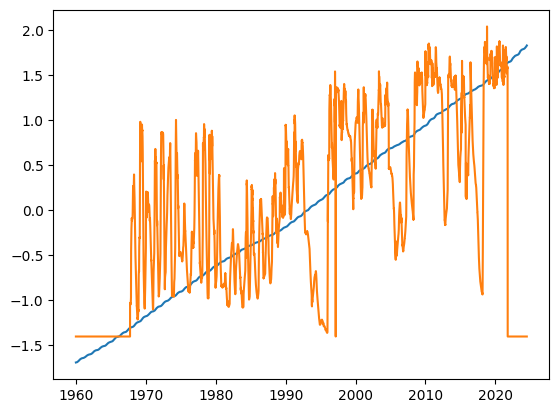

In [168]:
pixel = 26
df_pixel= df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == pixel]
scaler = StandardScaler()
df_pixel_scaled = pd.DataFrame(scaler.fit_transform(df_pixel), columns=df_pixel.columns, index=df_pixel.index)
plt.plot(df_pixel_scaled['agua_disponible_cum'])
plt.plot(df_pixel_scaled['quantity_hm3_embalses'])

plt.show()

#### Ejemplo Pixel 21

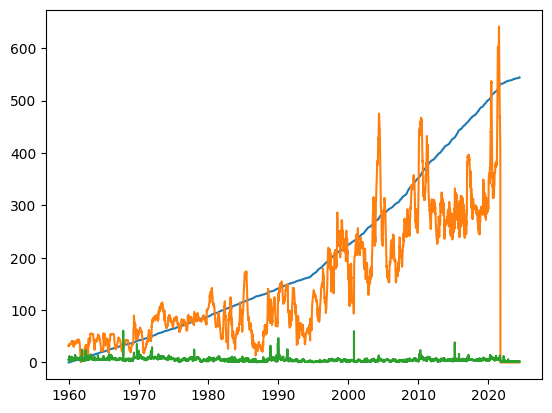

In [118]:
pixel21 = df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == 21]
plt.plot(pixel21['agua_disponible_cum'])
plt.plot(pixel21['quantity_hm3_embalses'])

plt.show()

In [129]:
pixel21.corr()['quantity_hm3_embalses'].sort_values(ascending=False)

quantity_hm3_embalses                1.000000
cambiosNoObs                         0.999696
high_vegetation_cover                0.886583
low_vegetation_cover                 0.886583
type_high_vegetation                 0.886583
type_low_vegetation                  0.886583
skin_temperature                     0.885616
soil_water                           0.846813
agDisp_semestre_anterior             0.811155
agDisp_año_anterior                  0.761726
precipitaciones_semestre_anterior    0.738304
precipitaciones_anio_anterior        0.734997
agDisp_mes_anterior                  0.677269
agua_disponible_estimacion           0.674898
agua_disponible_cum                  0.669235
precipitaciones_mes_anterior         0.535276
total_precipitation                  0.178505
total_precipitation_sqrt             0.109325
runoff                               0.109059
quantity_hm3_riosCanales             0.061418
snowfall                             0.040826
evaporation                       

In [126]:
scaler = StandardScaler()
pixel21_scaled = pd.DataFrame(scaler.fit_transform(pixel21), columns=pixel21.columns, index=pixel21.index)

In [141]:
regresion(X =pixel21_scaled[['agua_disponible_cum','high_vegetation_cover']] , y = pixel21_scaled['quantity_hm3_embalses'], const=0).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     quantity_hm3_embalses   R-squared (uncentered):                   0.787
Model:                               OLS   Adj. R-squared (uncentered):              0.787
Method:                    Least Squares   F-statistic:                          4.356e+04
Date:                   Fri, 04 Oct 2024   Prob (F-statistic):                        0.00
Time:                           17:02:47   Log-Likelihood:                         -15203.
No. Observations:                  23558   AIC:                                  3.041e+04
Df Residuals:                      23556   BIC:                                  3.043e+04
Df Model:                              2                                                  
Covariance Type:               nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
agua_disponible_cum      -0.0534      0.005    -11.156      0.000      -0.063      -0.044
high_vegetation_cover     0.9282      0.005    193.774      0.000       0.919       0.938
==============================================================================
Omnibus:                     7374.175   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41306.937
Skew:                           1.395   Prob(JB):                         0.00
Kurtosis:                       8.856   Cond. No.                         2.83
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Agrupación de píxeles (clustering)

In [10]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import KShape

##### Clustering por series temporales

In [120]:
df = df_merge_rios_embalses.copy()

# Variables que queremos usar en el clustering
variables = ['quantity_hm3_embalses']

# Pivotar el DataFrame para obtener la serie temporal para cada píxel
data = []
for pixel_id, pixel_data in df.groupby('pixel'):
    pixel_data = pixel_data.sort_values('date')  # Ordenar por fecha
    # Seleccionar solo las variables deseadas y convertir a un array de NumPy
    pixel_array = pixel_data[variables].to_numpy()
    data.append(pixel_array)

# Convertir la lista de arrays en un array de 3 dimensiones: (n_samples, n_timestamps, n_features)
data = np.array(data)

In [121]:
scaler = StandardScaler()

# Crear una lista para almacenar las series estandarizadas
scaled_data = []

for pixel_array in data:
    # Ajustar y transformar las variables del pixel
    scaled_pixel_array = scaler.fit_transform(pixel_array)
    scaled_data.append(scaled_pixel_array)

# Convertir la lista de arrays en un array de 3 dimensiones: (n_samples, n_timestamps, n_features)
scaled_data = np.array(scaled_data)

In [122]:
# Número de clusters deseados
n_clusters = 3

# Aplicar K-Shape
kshape = KShape(n_clusters=n_clusters, random_state=42)

In [ ]:
clusters = kshape.fit_predict(scaled_data)

In [ ]:
df_merge_rios_embalses['cluster'] = df_merge_rios_embalses['pixel'].map(lambda x: clusters[x])

In [ ]:
for i in df_merge_rios_embalses['cluster'].unique():
    print('Cluster:',i)
    cluster_i = df_merge_rios_embalses[df_merge_rios_embalses['cluster'] == i]
    print('Número de píxeles:',len(cluster_i['pixel'].unique()))
    for pixel in cluster_i['pixel'].unique():
        pixel_cluster = cluster_i[cluster_i['pixel'] == pixel]
        plt.plot(pixel_cluster['quantity_hm3_embalses'])
    plt.show()

##### Clustering por propiedades estadísticas agregadas

In [70]:
from sklearn.cluster import KMeans
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\nacho\mambaforge\envs\myenv\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


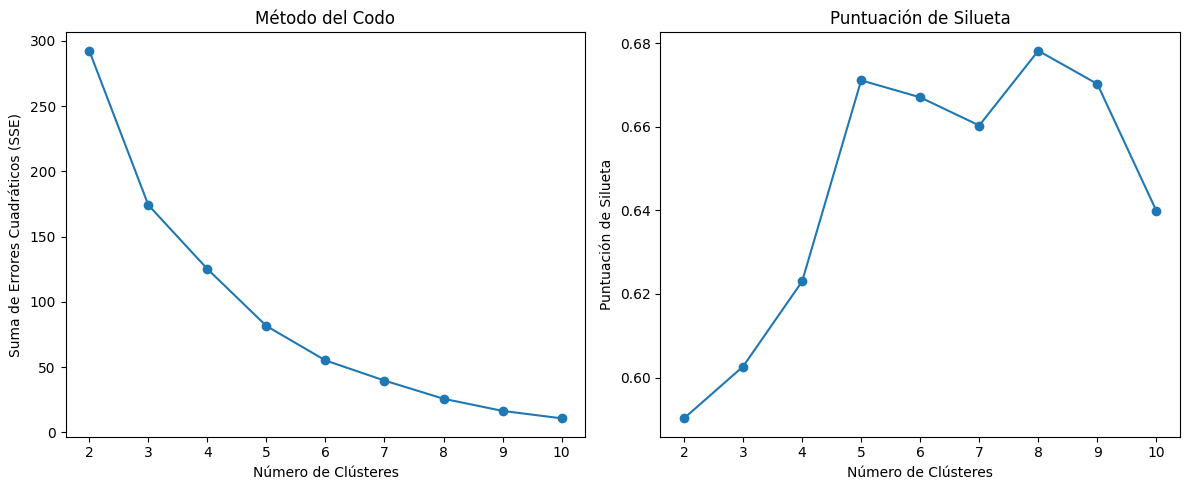

In [116]:
#df_merge_rios_embalses = df_merge_rios_embalses.reset_index()

variables_climaticas = ['quantity_hm3_embalses']
def calcular_caracteristicas(grupo):
    estadisticas = {}
    for var in variables_climaticas:
        # Tendencia
        x = np.arange(len(grupo))
        y = grupo[var].values
        if len(x) > 1:
            tendencia = np.polyfit(x, y, 1)[0]  # Coeficiente de pendiente
        else:
            tendencia = 0
        
        # Estacionalidad: media y std por año
        media_anual = grupo.groupby(grupo['date'].dt.year)[var].mean().mean()
        std_anual = grupo.groupby(grupo['date'].dt.year)[var].std().mean()
        
        # Número de picos
        picos, _ = find_peaks(y)
        num_picos = len(picos)
        
        # Número de caídas (valores por debajo de la media)
        num_caidas = np.sum(np.diff(y) < 0)

        # Varianza
        varianza = grupo[var].var()
        
        # Rango intercuartílico
        iqr = np.percentile(grupo[var], 75) - np.percentile(grupo[var], 25)
        # Media móvil
        media_movil_7 = grupo[var].rolling(window=7).mean().mean()
        media_movil_30 = grupo[var].rolling(window=30).mean().mean()
        
        # Desviación estándar móvil
        std_movil_7 = grupo[var].rolling(window=7).std().mean()
        std_movil_30 = grupo[var].rolling(window=30).std().mean()
        
        # Autocorrelación
        autocorr_1 = grupo[var].autocorr(lag=1)
        autocorr_7 = grupo[var].autocorr(lag=7)
        
        # Máximos y mínimos
        max_val = grupo[var].max()
        min_val = grupo[var].min()
        
        # Curtosis y asimetría
        curtosis = grupo[var].kurtosis()
        asimetria = grupo[var].skew()
        
        # Rango
        rango = max_val - min_val
        
        # Proporción de tiempo por encima de la media
        proporcion_sobre_media = (grupo[var] > grupo[var].mean()).mean()
        
        # Cambio porcentual
        cambio_porcentual = (grupo[var].pct_change()).mean()
        
        # Agregar características al diccionario
        estadisticas['trend'] = tendencia
        estadisticas['seasonal_mean'] = media_anual
        estadisticas['seasonal_std'] = std_anual
        estadisticas['num_peaks'] = num_picos
        estadisticas['num_drops'] = num_caidas
        estadisticas['variance'] = varianza
        estadisticas['IQR'] = iqr
        estadisticas['media_movil_7'] = media_movil_7
        estadisticas['media_movil_30'] = media_movil_30
        estadisticas['std_movil_7'] = std_movil_7
        estadisticas['std_movil_30'] = std_movil_30
        estadisticas['autocorr_1'] = autocorr_1
        estadisticas['autocorr_7'] = autocorr_7
        estadisticas['max'] = max_val
        estadisticas['min'] = min_val
        estadisticas['curtosis'] = curtosis
        estadisticas['asimetria'] = asimetria
        estadisticas['rango'] = rango
        estadisticas['proporcion_sobre_media'] = proporcion_sobre_media
        estadisticas['cambio_porcentual'] = cambio_porcentual
    
    return pd.Series(estadisticas)
df_caracteristicas = df_merge_rios_embalses.groupby('pixel').apply(calcular_caracteristicas).reset_index()
df_caracteristicas.replace([np.inf, -np.inf], 0, inplace=True)  # Reemplazar inf y -inf por 0
df_caracteristicas.fillna(0, inplace=True)
# Normalizar las características para el clustering
scaler = StandardScaler()
X = scaler.fit_transform(df_caracteristicas.drop(columns=['pixel']))

# Método del Codo
sse = []
silhouette_scores = []
k_values = range(2, 11)  # Probar con 2 a 10 clústeres

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # SSE
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))  # Silhouette Score

# Gráfica del método del codo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')

# Gráfica de la puntuación de Silueta
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Puntuación de Silueta')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntuación de Silueta')

plt.tight_layout()
plt.show()

In [117]:
# Aplicar KMeans
kmeans = KMeans(n_clusters=5,n_init=10, random_state=42)  # Ajusta el número de clústeres según sea necesario
kmeans.fit(X)

# Añadir las etiquetas de clúster al DataFrame de características
df_caracteristicas['cluster'] = kmeans.labels_

In [118]:

clusters_df = pd.DataFrame({
    'pixel': df_caracteristicas['pixel'],  # Asegúrate de incluir la columna de píxel
    'cluster': kmeans.labels_  # Las etiquetas de los clústeres
})

# 2. Unir el DataFrame original con el DataFrame de clústeres
df_final = pd.merge(df_merge_rios_embalses, clusters_df, on='pixel', how='left')
df_final.set_index('date', inplace = True)

Cluster: 2
Número de píxeles: 15


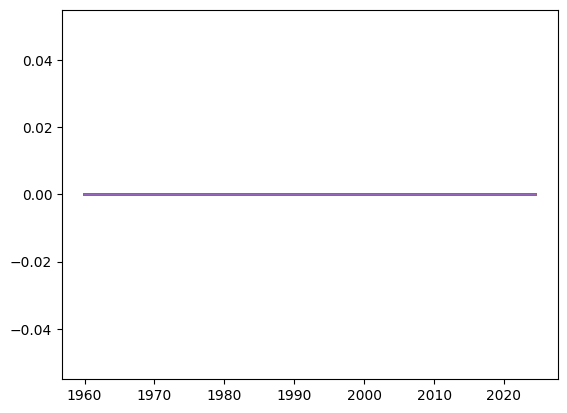

Cluster: 4
Número de píxeles: 7


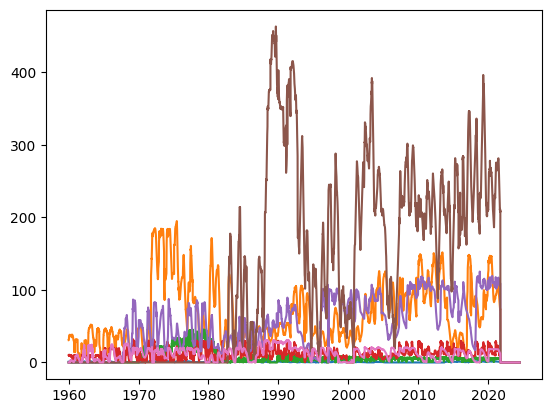

Cluster: 3
Número de píxeles: 3


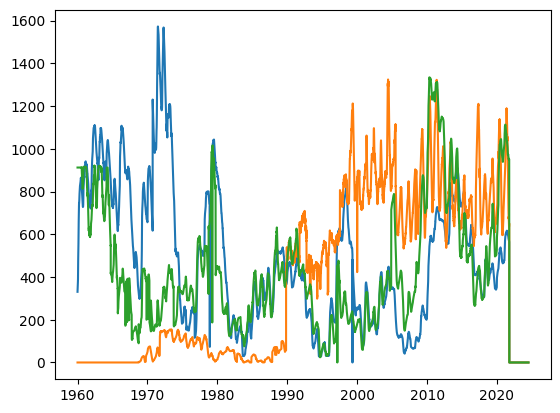

Cluster: 1
Número de píxeles: 3


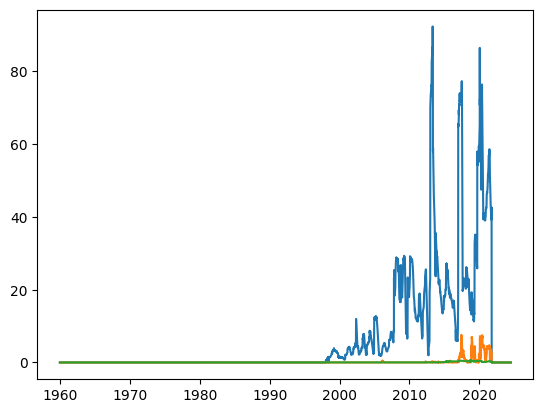

Cluster: 0
Número de píxeles: 2


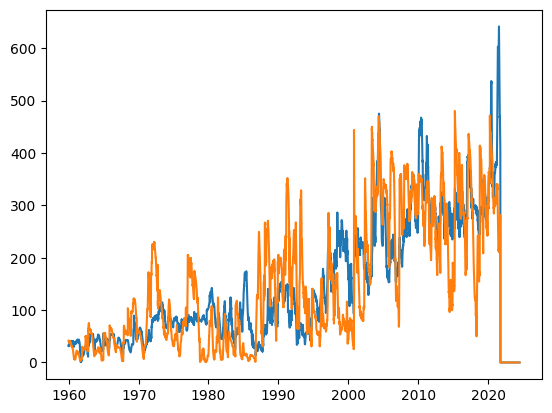

In [119]:
for i in df_final['cluster_y'].unique():
    print('Cluster:',i)
    cluster_i = df_final[df_final['cluster_y'] == i]
    print('Número de píxeles:',len(cluster_i['pixel'].unique()))
    for pixel in cluster_i['pixel'].unique():
        pixel_cluster = cluster_i[cluster_i['pixel'] == pixel]
        plt.plot(pixel_cluster['quantity_hm3_embalses'])
    plt.show()

##### Clustering serie temporal k_means

In [63]:
from sklearn.cluster import KMeans
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

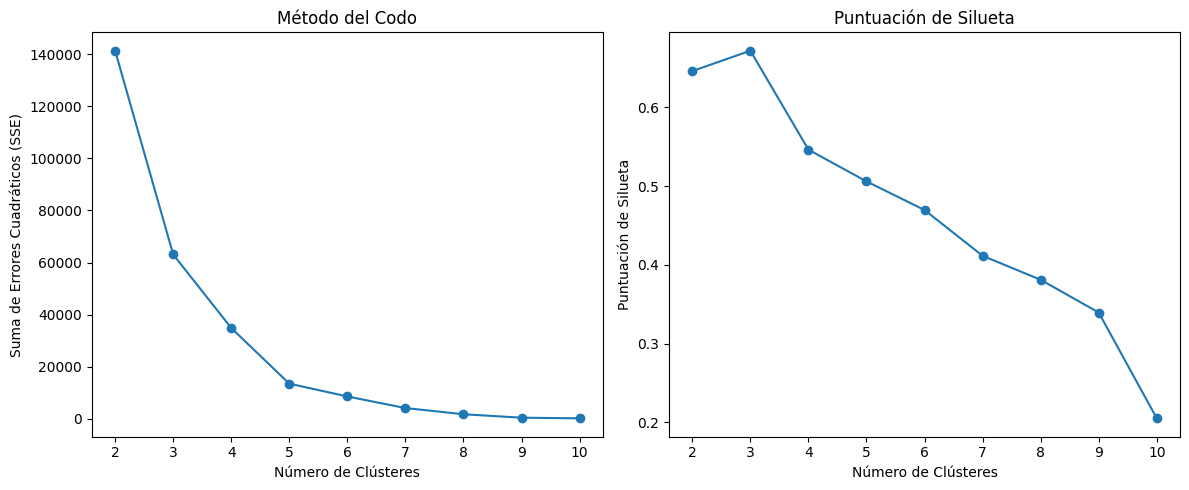

In [106]:
df = df_merge_rios_embalses.reset_index()
df_pixeles = {}

for pixel, grupo in df.groupby('pixel'):
    grupo_ordenado = grupo.sort_values(by='date')
    serie_temporal = grupo_ordenado['quantity_hm3_embalses'].reset_index(drop=True)
    #serie_temporal = serie_temporal.set_index('date')
    df_pixeles[f'pixel_{pixel}'] = serie_temporal

df_pixeles = pd.DataFrame(df_pixeles)
df_pixeles = df_pixeles.loc[:, (df_pixeles != 0).any(axis=0)]
df_pixeles_cluster = df_pixeles.T

scaler = StandardScaler()
X = scaler.fit_transform(df_pixeles_cluster)

# Método del Codo
sse = []
silhouette_scores = []
k_values = range(2, 11)  # Probar con 2 a 10 clústeres

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # SSE
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))  # Silhouette Score

# Gráfica del método del codo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')

# Gráfica de la puntuación de Silueta
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Puntuación de Silueta')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntuación de Silueta')

plt.tight_layout()
plt.show()

Cluster: 3.0
Número de píxeles: 15


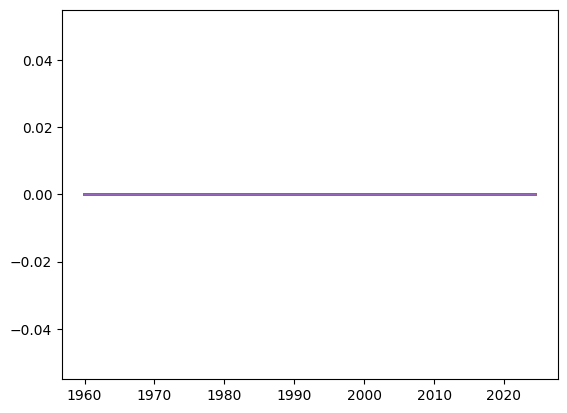

Cluster: 1.0
Número de píxeles: 12


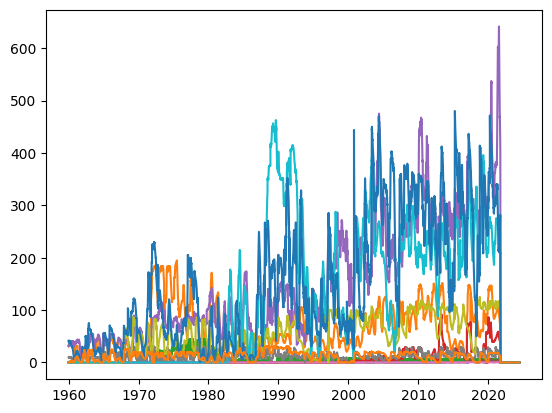

Cluster: 0.0
Número de píxeles: 2


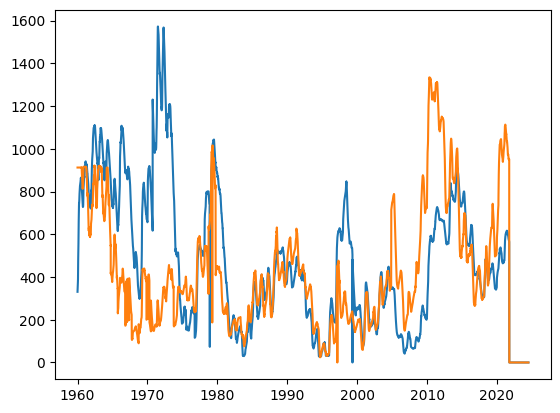

Cluster: 2.0
Número de píxeles: 1


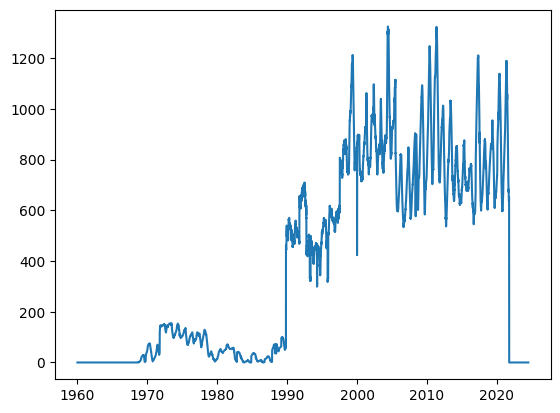

In [110]:
# Aplicar KMeans
kmeans = KMeans(n_clusters=3,n_init=10, random_state=42)  # Ajusta el número de clústeres según sea necesario
kmeans.fit(X)

# Añadir las etiquetas de clúster al DataFrame de características
df_pixeles_cluster['cluster'] = kmeans.labels_

df_pixeles_cluster['pixel'] = df_pixeles_cluster.index.str.split('_').str[1].astype(int)

df_merged = df.merge(df_pixeles_cluster[['pixel', 'cluster']], on='pixel', how='left')
df_merged['cluster']= df_merged['cluster'].fillna(3)
df_merged = df_merged.set_index('date')

for i in df_merged['cluster'].unique():
    print('Cluster:',i)
    cluster_i = df_merged[df_merged['cluster'] == i]
    print('Número de píxeles:',len(cluster_i['pixel'].unique()))
    for pixel in cluster_i['pixel'].unique():
        pixel_cluster = cluster_i[cluster_i['pixel'] == pixel]
        plt.plot(pixel_cluster['quantity_hm3_embalses'])
    plt.show()

##### Clustering manual

In [102]:
df = df_merge_rios_embalses.reset_index()

df_pixeles = {}

for pixel, grupo in df.groupby('pixel'):
    grupo_ordenado = grupo.sort_values(by='date')
    serie_temporal = grupo_ordenado['hm3_estacion_embalse'].reset_index(drop=True)
    #serie_temporal = serie_temporal.set_index('date')
    df_pixeles[f'pixel_{pixel}'] = serie_temporal

df_pixeles = pd.DataFrame(df_pixeles)
df_pixeles = df_pixeles.fillna(0)
columnas_todo_cero = df_pixeles.columns[(df_pixeles == 0).all(axis=0)].tolist()
df_pixeles = df_pixeles.loc[:, (df_pixeles != 0).any(axis=0)]

tendencias_crecimiento = df_pixeles.diff().fillna(0)  # Calculamos la diferencia entre cada fila
tendencias_crecimiento = np.where(tendencias_crecimiento > 0, 1, -1) 
tendencias_crecimiento = pd.DataFrame(tendencias_crecimiento, index=df_pixeles.index, columns=df_pixeles.columns)
semejanza = pd.DataFrame(index=tendencias_crecimiento.columns, columns=tendencias_crecimiento.columns)

# Iteramos sobre cada par de columnas (píxeles)
for col1 in tendencias_crecimiento.columns:
    for col2 in tendencias_crecimiento.columns:
        # Coincidencias de crecimientos y decrecimientos
        coincidencias = (tendencias_crecimiento[col1] == tendencias_crecimiento[col2]).sum()
        total_puntos = len(df_pixeles)
        
        # Calculamos el porcentaje de coincidencias
        semejanza.loc[col1, col2] = coincidencias / total_puntos
semejanza = semejanza.astype(float)

In [103]:
semejanza_corr = df_pixeles.corr()

In [105]:
def agrupar_pixeles_por_semejanza(semejanza_tendencias, umbral=0.8):
    """
    Agrupa píxeles con una semejanza mayor que un umbral, asegurando que cada pixel esté en un solo grupo.
    """
    grupos = []
    agrupados = set()  # Para registrar los píxeles que ya están agrupados

    # Iterar sobre cada pixel
    for pixel in semejanza_tendencias.index:
        if pixel in agrupados:
            continue  # Saltamos si el pixel ya está agrupado

        # Crear un grupo para el pixel actual
        grupo_actual = [pixel]
        agrupados.add(pixel)

        # Iteramos sobre otros píxeles no agrupados aún
        for otro_pixel in semejanza_tendencias.columns:
            if otro_pixel != pixel and otro_pixel not in agrupados:
                if semejanza_tendencias.loc[pixel, otro_pixel] >= umbral:
                    grupo_actual.append(otro_pixel)
                    agrupados.add(otro_pixel)
        
        # Comprobar si el pixel pertenece a un grupo existente con mayor semejanza
        grupo_asignado = None
        for grupo in grupos:
            for miembro in grupo:
                if semejanza_tendencias.loc[pixel, miembro] >= umbral:
                    grupo_asignado = grupo
                    break
            if grupo_asignado:
                break

        # Si el píxel tiene más semejanza con un grupo existente, añadirlo a ese grupo
        if grupo_asignado:
            grupo_asignado.extend(grupo_actual)
            agrupados.update(grupo_actual)
        else:
            # Si no tiene más semejanza con otro grupo, añadimos el nuevo grupo
            grupos.append(grupo_actual)
    
    return grupos

# Llamada a la función para agrupar píxeles con semejanza mayor al 60%
grupos_pixeles_corr = agrupar_pixeles_por_semejanza(semejanza_corr, umbral=0.6)
grupos_pixeles_crec = agrupar_pixeles_por_semejanza(semejanza, umbral=0.75)

In [106]:
grupos_pixeles_corr

[['pixel_8'],
 ['pixel_10'],
 ['pixel_12', 'pixel_20'],
 ['pixel_14'],
 ['pixel_15', 'pixel_21', 'pixel_26', 'pixel_28', 'pixel_16', 'pixel_24'],
 ['pixel_22'],
 ['pixel_25'],
 ['pixel_27'],
 ['pixel_29']]

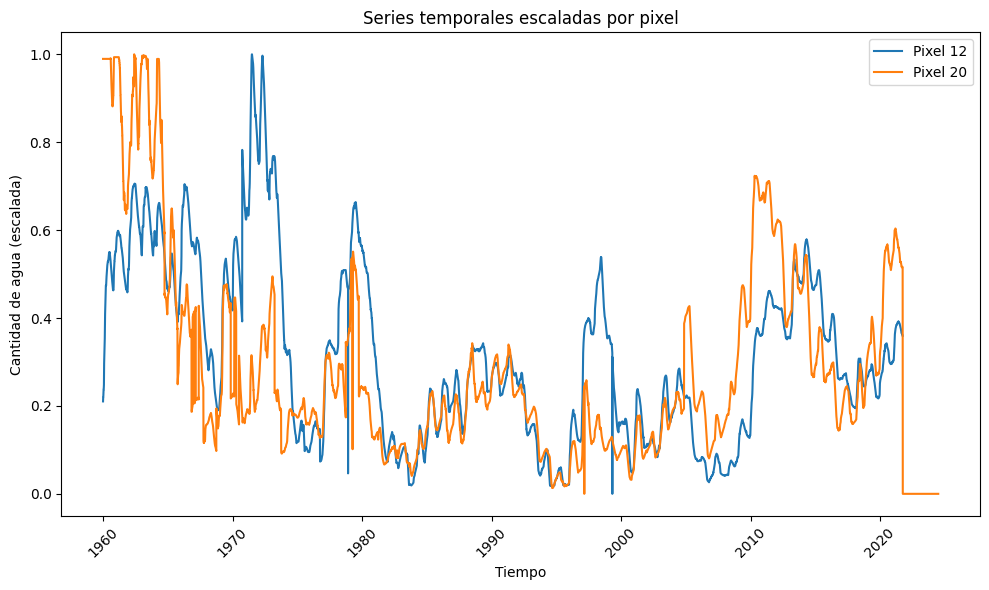

In [107]:
from sklearn.preprocessing import MinMaxScaler

# Filtrar las series temporales para los píxeles que queremos comparar
pixels = [12, 20]

df_filtered = df_merge_rios_embalses.reset_index()
df_filtered = df_filtered[df_filtered['pixel'].isin(pixels)][['pixel', 'hm3_estacion_embalse', 'date']]

# Inicializar el scaler
scaler = MinMaxScaler()

# Crear un diccionario para almacenar las series escaladas
scaled_series = {}

# Escalar cada serie temporal por pixel manteniendo el índice temporal
for pixel in pixels:
    # Filtrar la serie temporal por pixel y conservar el índice de tiempo (columna 'date')
    series = df_filtered[df_filtered['pixel'] == pixel].set_index('date')['hm3_estacion_embalse']
    
    # Aplicar el escalado y mantener el índice de tiempo
    scaled_series[pixel] = pd.Series(scaler.fit_transform(series.values.reshape(-1, 1)).flatten(), index=series.index)

# Graficar las series escaladas
plt.figure(figsize=(10, 6))
for pixel in pixels:
    plt.plot(scaled_series[pixel], label=f'Pixel {pixel}')

# Añadir leyenda y mostrar el gráfico
plt.title('Series temporales escaladas por pixel')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de agua (escalada)')
plt.legend()
plt.xticks(rotation=45)  # Rotar las etiquetas de tiempo si es necesario
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()

### Estimación conjunta

#### Regresiones

                             OLS Regression Results                             
Dep. Variable:     hm3_estacion_embalse   R-squared:                       0.609
Model:                              OLS   Adj. R-squared:                  0.609
Method:                   Least Squares   F-statistic:                     4586.
Date:                  Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                          16:30:08   Log-Likelihood:            -1.6824e+05
No. Observations:                 23558   AIC:                         3.365e+05
Df Residuals:                     23549   BIC:                         3.366e+05
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

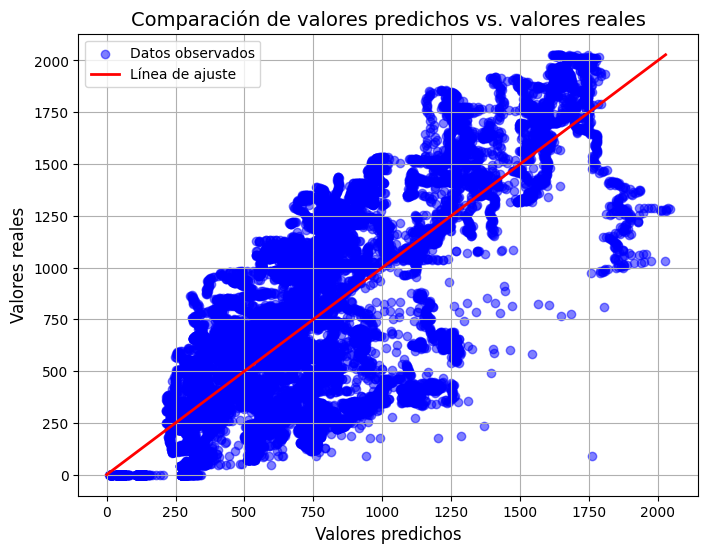

In [175]:
df_pixelesconjuntos = df_merge_rios_embalses[(df_merge_rios_embalses['pixel'] == 12) | (df_merge_rios_embalses['pixel'] == 20)]
df_pixelesconjuntos.reset_index(inplace = True)
df_pixelesconjuntos = df_pixelesconjuntos.groupby('date').sum().drop('pixel', axis = 1)

X = df_pixelesconjuntos.drop(['hm3_estacion_embalse','quantity_hm3_embalses','n_estaciones_embalses'], axis = 1)  # Añade más variables si es necesario
y = df_pixelesconjuntos['hm3_estacion_embalse']

# Estandarización de X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Paso 1: Ajustar un árbol de regresión para seleccionar las 5 características más importantes
tree_model = DecisionTreeRegressor()
tree_model.fit(X_scaled, y)

# Obtener las importancias de las características
feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)

# Seleccionamos las 5 características más importantes
top_features = feature_importances.nlargest(8).index.tolist()

# Paso 2: Usamos las características seleccionadas en la regresión
X_top = X_scaled[top_features]

# Agregamos la constante para statsmodels
X_top = sm.add_constant(X_top, has_constant='add')

# Ajustamos el modelo de regresión lineal
model = sm.OLS(y, X_top).fit()
print(model.summary())

# Paso 1: Predecir los valores de hm3_estacion_embalse usando el modelo ajustado
y_pred = model.predict(X_top)

# Paso 2: Crear una gráfica de dispersión para comparar los valores reales (y) con los predichos (y_pred)
plt.figure(figsize=(8, 6))

# Nube de puntos
plt.scatter(y_pred, y, color='blue', alpha=0.5, label='Datos observados')

# Línea de ajuste (x = y, perfecta correspondencia entre predicción y realidad)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Línea de ajuste')

# Etiquetas de los ejes
plt.xlabel('Valores predichos', fontsize=12)
plt.ylabel('Valores reales', fontsize=12)

# Título y leyenda
plt.title('Comparación de valores predichos vs. valores reales', fontsize=14)
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

['pixel_15', 'pixel_21', 'pixel_26', 'pixel_28', 'pixel_16', 'pixel_24'],]

                             OLS Regression Results                             
Dep. Variable:     hm3_estacion_embalse   R-squared:                       0.791
Model:                              OLS   Adj. R-squared:                  0.791
Method:                   Least Squares   F-statistic:                 1.113e+04
Date:                  Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                          16:30:14   Log-Likelihood:            -1.3442e+05
No. Observations:                 23558   AIC:                         2.689e+05
Df Residuals:                     23549   BIC:                         2.689e+05
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

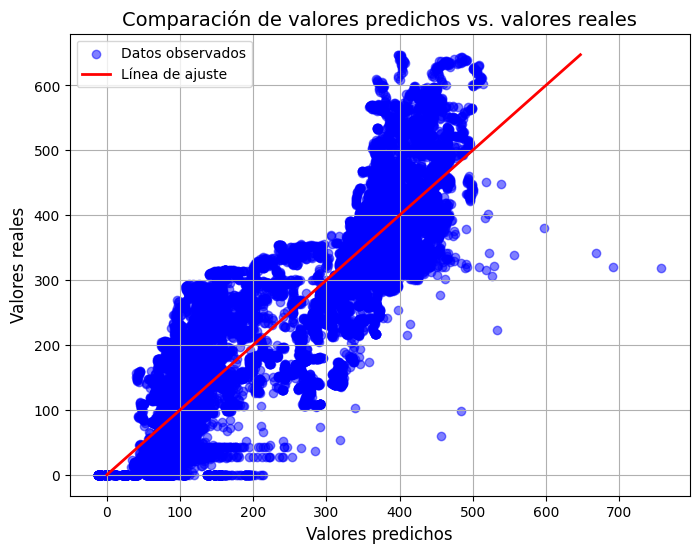

In [176]:
df_pixelesconjuntos = df_merge_rios_embalses[(df_merge_rios_embalses['pixel'] == 15) | (df_merge_rios_embalses['pixel'] == 21) | (df_merge_rios_embalses['pixel'] == 26) | (df_merge_rios_embalses['pixel'] == 28) | (df_merge_rios_embalses['pixel'] == 16) | (df_merge_rios_embalses['pixel'] == 24)]
df_pixelesconjuntos.reset_index(inplace = True)
df_pixelesconjuntos = df_pixelesconjuntos.groupby('date').sum().drop('pixel', axis = 1)

X = df_pixelesconjuntos.drop(['hm3_estacion_embalse','quantity_hm3_embalses','n_estaciones_embalses'], axis = 1)  # Añade más variables si es necesario
y = df_pixelesconjuntos['hm3_estacion_embalse']

# Estandarización de X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Paso 1: Ajustar un árbol de regresión para seleccionar las 5 características más importantes
tree_model = DecisionTreeRegressor()
tree_model.fit(X_scaled, y)

# Obtener las importancias de las características
feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)

# Seleccionamos las 5 características más importantes
top_features = feature_importances.nlargest(8).index.tolist()

# Paso 2: Usamos las características seleccionadas en la regresión
X_top = X_scaled[top_features]

# Agregamos la constante para statsmodels
X_top = sm.add_constant(X_top, has_constant='add')

# Ajustamos el modelo de regresión lineal
model = sm.OLS(y, X_top).fit()
print(model.summary())

# Paso 1: Predecir los valores de hm3_estacion_embalse usando el modelo ajustado
y_pred = model.predict(X_top)

# Paso 2: Crear una gráfica de dispersión para comparar los valores reales (y) con los predichos (y_pred)
plt.figure(figsize=(8, 6))

# Nube de puntos
plt.scatter(y_pred, y, color='blue', alpha=0.5, label='Datos observados')

# Línea de ajuste (x = y, perfecta correspondencia entre predicción y realidad)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Línea de ajuste')

# Etiquetas de los ejes
plt.xlabel('Valores predichos', fontsize=12)
plt.ylabel('Valores reales', fontsize=12)

# Título y leyenda
plt.title('Comparación de valores predichos vs. valores reales', fontsize=14)
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

#### Ajuste polinomial

In [178]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

R^2 del modelo polinomial: 0.9173


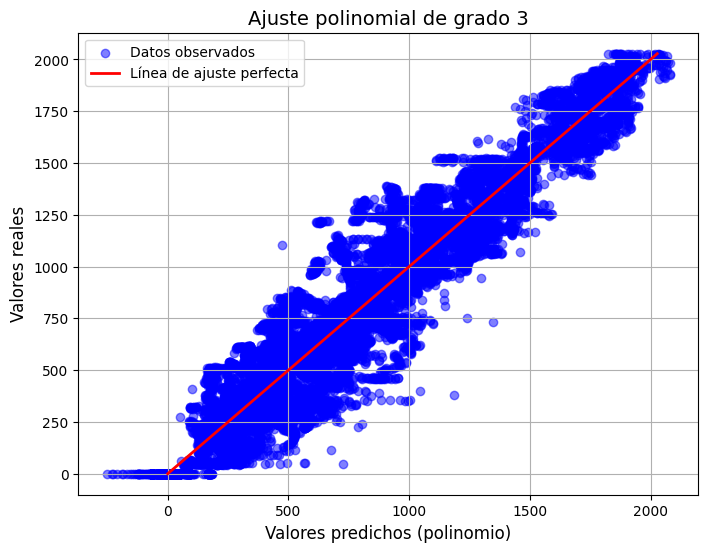

In [205]:
# Seleccionar los píxeles 12 y 20
df_pixelesconjuntos = df_merge_rios_embalses[(df_merge_rios_embalses['pixel'] == 12) | (df_merge_rios_embalses['pixel'] == 20)]
df_pixelesconjuntos.reset_index(inplace=True)
df_pixelesconjuntos = df_pixelesconjuntos.groupby('date').sum().drop('pixel', axis=1)

# Separar variables predictoras (X) y variable objetivo (y)
X = df_pixelesconjuntos.drop(['hm3_estacion_embalse', 'quantity_hm3_embalses', 'n_estaciones_embalses'], axis=1)
y = df_pixelesconjuntos['hm3_estacion_embalse']

# Estandarización de X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Paso 1: Ajustar un árbol de regresión para seleccionar las 8 características más importantes
tree_model = DecisionTreeRegressor()
tree_model.fit(X_scaled, y)

# Obtener las importancias de las características
feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)

# Seleccionar las 8 características más importantes
top_features = feature_importances.nlargest(8).index.tolist()

# Paso 2: Ajuste polinomial (grado 3) con las características seleccionadas
X_top = X_scaled[top_features]

# Generar términos polinomiales (grado 3)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_top)

# Ajustamos el modelo de regresión polinomial
poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Predecir los valores de hm3_estacion_embalse usando el modelo polinomial
y_pred_poly = poly_model.predict(X_poly)

# Medida de eficiencia: R^2 polinomial
r2_poly = r2_score(y, y_pred_poly)
print(f'R^2 del modelo polinomial: {r2_poly:.4f}')

# Gráfica de ajuste polinomial
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_poly, y, color='blue', alpha=0.5, label='Datos observados')

# Línea de ajuste (x=y)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Línea de ajuste perfecta')

# Etiquetas y título
plt.xlabel('Valores predichos (polinomio)', fontsize=12)
plt.ylabel('Valores reales', fontsize=12)
plt.title('Ajuste polinomial de grado 3', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [208]:
# Opcional: Mostrar los términos polinomiales más significativos
coef_df = pd.DataFrame({
    'Coeficiente': model.params,
    'P-valor': model.pvalues
}).sort_values(by='P-valor')

print(coef_df.head(10)) 

                                   Coeficiente        P-valor
const                               741.009328   0.000000e+00
n_estaciones_rios                   278.115185   0.000000e+00
quantity_hm3_riosCanales            210.478027   0.000000e+00
pixel_copernicus                    251.790955   0.000000e+00
agDisp_semestre_anterior             73.617000  3.739929e-176
agDisp_mes_anterior                  70.683574  3.574859e-124
hm3_estacion_rio                    -90.218049   6.478688e-91
precipitaciones_semestre_anterior    49.345733   8.449545e-81
skin_temperature                    188.444204   3.471743e-10
precipitaciones_anio_anterior        25.246711   4.098818e-09


#### Red bayesiana

  0%|          | 0/1000000 [00:00<?, ?it/s]

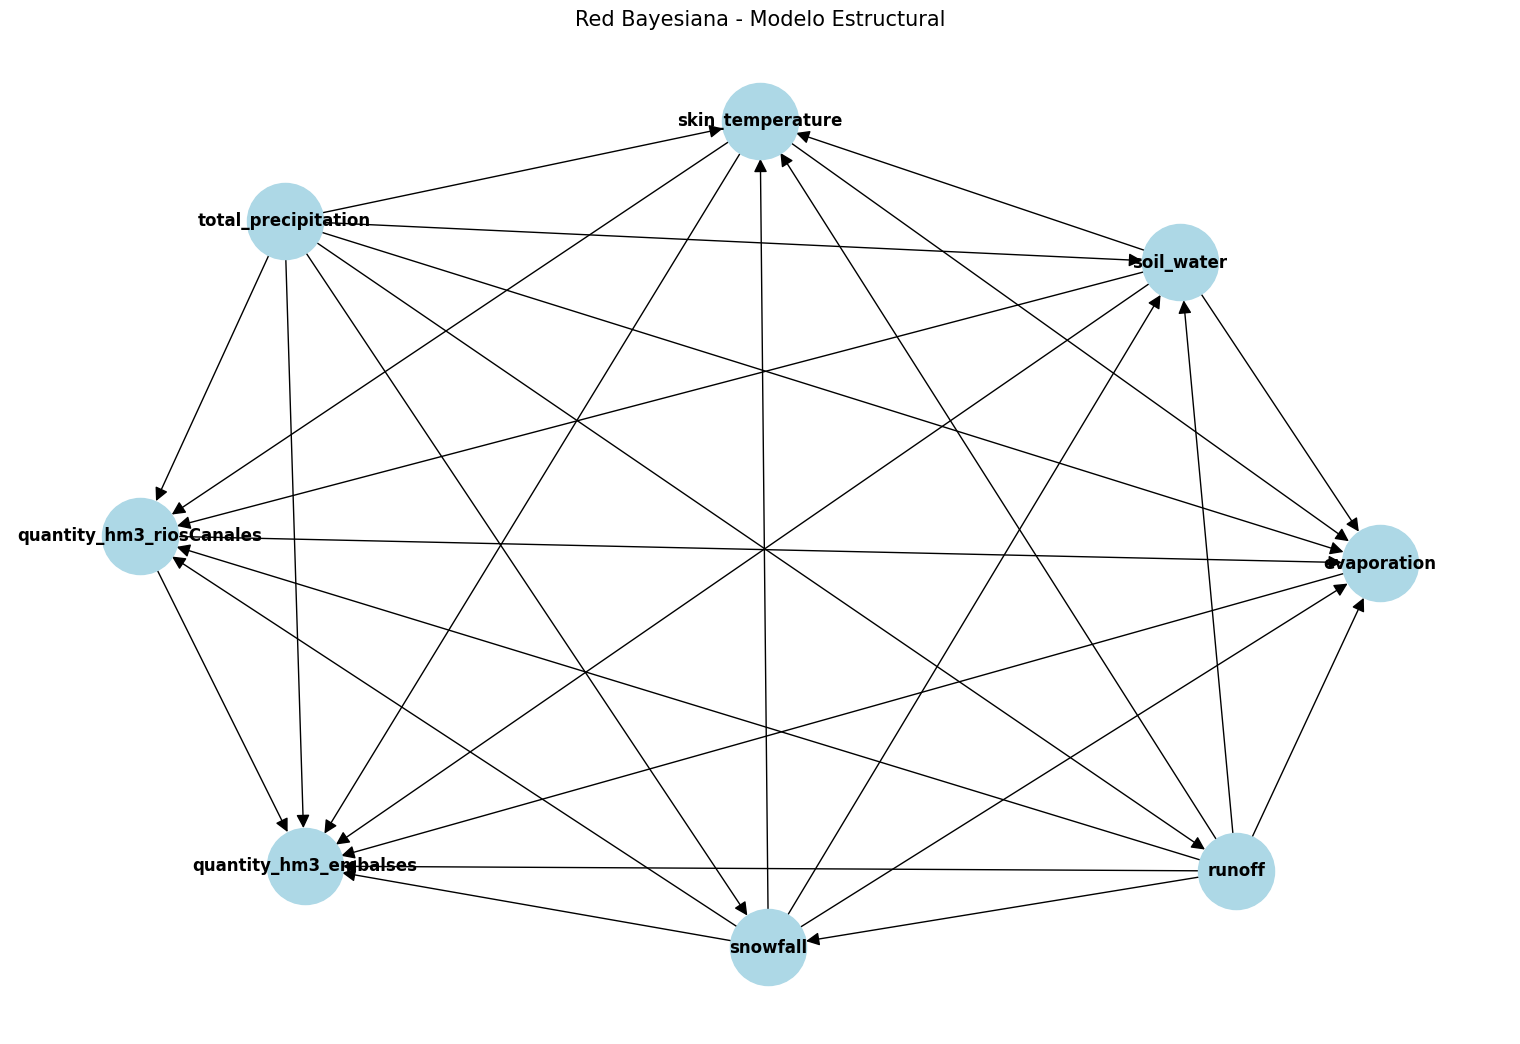

In [172]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, BicScore
from pgmpy.inference import VariableElimination
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df_rios_embalses_bayes  = df_merge_rios_embalses.copy()
####discretización

# Variables que se discretizan por la media
variables_media = ['quantity_hm3_embalses', 'skin_temperature', 'evaporation','soil_water', 'quantity_hm3_riosCanales']

# Variables que se discretizan por comparación con 0
variables_comparacion = ['total_precipitation', 'runoff', 'snowfall']

# Discretización de las variables por la media
for col in variables_media:
    media_col = df_rios_embalses_bayes[col].mean()
    df_rios_embalses_bayes[col] = (df_rios_embalses_bayes[col] > media_col).astype(int)

# Discretización de las variables por comparación con 0
for col in variables_comparacion:
    df_rios_embalses_bayes[col] = (df_rios_embalses_bayes[col] != 0).astype(int)
df_rios_embalses_bayes = df_rios_embalses_bayes[['quantity_hm3_embalses', 'skin_temperature', 'evaporation','soil_water', 'quantity_hm3_riosCanales','total_precipitation', 'runoff', 'snowfall']]

hc = HillClimbSearch(df_rios_embalses_bayes)
mejor_modelo = hc.estimate(scoring_method=BicScore(df_rios_embalses_bayes))

# Ver la estructura aprendida
grafo = mejor_modelo.edges()

edges = grafo
# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir las relaciones al grafo
G.add_edges_from(edges)

# Dibujar el grafo
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=4, seed=42)  # Layout del grafo
nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold', node_size=3000, arrowsize=20)

# Mostrar el grafo
plt.title('Red Bayesiana - Modelo Estructural', size=15)
plt.show()

In [ ]:
quiero poner en un markdown las 

## Borrador

##### Cambios de agua no observados
$\text{Agua disponible} = \text{Agua disponible estimada} + \text{u}$

$\text{Agua disponible} = ((\text{Total precipitation} + \text{snowfall} + \text{soil water}) - (\text{evaporation} + \text{runoff})) + \text{u}$

$\text{u} = \text{Agua disponible} - (\text{Total precipitation} + \text{snowfall} + \text{soil water} - (\text{evaporation} + \text{runoff}))$


In [240]:
df_merge_rios_embalses['cambiosNoObs'] = (df_merge_rios_embalses['quantity_hm3_embalses'] + df_merge_rios_embalses['quantity_hm3_riosCanales'])  - df_merge_rios_embalses['agua_disponible_estimacion']
ruido_promedio = {}
for pixel in df_merge_rios_embalses['pixel'].unique():
    df_pixel = df_merge_rios_embalses[df_merge_rios_embalses['pixel'] == pixel]
    ruido_promedio[pixel] = df_pixel['cambiosNoObs'].mean()

#df_merge_rios_embalses['agua_disponible'] = df_merge_rios_embalses['agua_disponible_estimacion'] + df_merge_rios_embalses['cambiosNoObs_promedio']

#### Cuenca hidrográfica del Jucar enlazada

In [147]:
chj = df_merge_rios_embalses.groupby(['date']).sum().reset_index()
df_merge_rios_embalses.set_index('date', inplace=True)
df_merge_rios_embalses = df_merge_rios_embalses.drop('pìxel', axis = 1)

In [188]:
chj.set_index('date', inplace=True)
aregresiones_df = regression_analysis(df = chj, features = ['total_precipitation', 'skin_temperature', 'evaporation', 'runoff', 'snowfall','soil_water',
               'high_vegetation_cover', 'low_vegetation_cover','agua_disponible_estimacion'], target = 'quantity_hm3_embalses')

In [211]:
regresiones_df = regression_analysis(df = chj, features = ['total_precipitation', 'skin_temperature', 'evaporation', 'runoff', 'snowfall','soil_water',
               'high_vegetation_cover', 'low_vegetation_cover','agua_disponible_estimacion'], target = 'quantity_hm3_embalses')